<a href="https://colab.research.google.com/github/prashant070800/Final-year-project/blob/main/FaceNet_complete_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final saved model

In [ ]:
from google.colab import driveo

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Training Images/'

/content/drive/MyDrive/Training Images


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import dependencies
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
from PIL import Image
import io
import html
import time
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
# function for face detection with mtcnn
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

from keras.models import load_model
%matplotlib inline

In [ ]:
# extract a single face from a given photograph
def extract_face(image, required_size=(160, 160)):
  # load image from file
	#image = Image.open(filename)
	# convert to RGB, if needed
  #image = image.convert('RGB')
  #print("new", image)
  #plt.imshow(image)
  pixels = np.asarray(image)

  detector = MTCNN()
  results = detector.detect_faces(pixels)
  x1, y1, width, height = results[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face = pixels[y1:y2, x1:x2]
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  return (face_array, results)

In [ ]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = numpy.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
model = load_model('/content/drive/MyDrive/Training Images/facenet/facenet_keras.h5')
print('Loaded Model')

data1 = load('/content/drive/MyDrive/Training Images/faces-dataset1.npz')
# load face embeddings
data = load('/content/drive/MyDrive/Training Images/faces-embeddings.npz')

Loaded Model


In [ ]:
testX_faces = data1['arr_2']
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
      # label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
      # fit model
model1 = SVC(kernel='linear', probability=True)
model1.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [ ]:
import requests
import IPython
from time import sleep


In [ ]:
# start streaming video from webcam
thres = 65
url = "https://9cbb-2409-4063-6e80-b006-4425-6741-3eb4-f9bf.in.ngrok.io"

video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    #img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(frame)
    # load the photo and extract the face
    try:
      pixels, results = extract_face(im_pil)
      yhat = get_embedding(model, pixels)

      
      newTestX = list()
      newTestX.append(yhat)
      newTestX = numpy.asarray(newTestX)


      # normalize input vectors
      in_encoder = Normalizer(norm='l2')
      trainX = in_encoder.transform(newTestX)

      yhat_class = model1.predict(trainX)
      yhat_prob = model1.predict_proba(trainX)

    
      asli_name = yhat_class[0]
      class_probability = yhat_prob[0,asli_name] * 100
      if(class_probability > thres):
        predict_names = out_encoder.inverse_transform(yhat_class)
        print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
        requests.post(f"{url}/user",{'first_name':predict_names[0],'last_name':''})
      else:
        print('Unknown')
        display(IPython.display.Audio(url="https://www.soundjay.com/buttons/sounds/beep-01a.mp3", autoplay=True))
        sleep(2)
        display(IPython.display.Audio(url="https://www.soundjay.com/buttons/sounds/beep-01a.mp3", autoplay=True))

        requests.post(f"{url}/user",{'first_name':"Unknown",'last_name':''})
      #print('Expected: %s' % random_face_name[0])
      #im_pil.show() 
    except:
      pass




<IPython.core.display.Javascript object>

Predicted: MANEESH (81.424)
Predicted: MANEESH (88.377)
Predicted: PRANJAL (76.228)
Predicted: PRANJAL (90.647)
Predicted: MANEESH (80.739)
Predicted: PRANJAL (84.716)
Unknown


Unknown


#End Here

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    #img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(frame)
    # load the photo and extract the face
    try:
      pixels, results = extract_face(im_pil)
      yhat = get_embedding(model, pixels)

      testX_faces = data1['arr_2']
      trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    
      in_encoder = Normalizer(norm='l2')
      trainX = in_encoder.transform(trainX)
      testX = in_encoder.transform(testX)
      # label encode targets
      out_encoder = LabelEncoder()
      out_encoder.fit(trainy)
      trainy = out_encoder.transform(trainy)
      testy = out_encoder.transform(testy)
      # fit model
      model1 = SVC(kernel='linear', probability=True)
      model1.fit(trainX, trainy)
      newTestX = list()
      newTestX.append(yhat)
      newTestX = numpy.asarray(newTestX)


      # normalize input vectors
      in_encoder = Normalizer(norm='l2')
      trainX = in_encoder.transform(newTestX)

      yhat_class = model1.predict(trainX)
      yhat_prob = model1.predict_proba(trainX)

      asli_name = yhat_class[0]
      asli_name = yhat_class[0]
      class_probability = yhat_prob[0,asli_name] * 100
      predict_names = out_encoder.inverse_transform(yhat_class)
      print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
      #print('Expected: %s' % random_face_name[0])
      #im_pil.show()
    except:
      print("No Face")



<IPython.core.display.Javascript object>

No Face
No Face
No Face
No Face
No Face
No Face
No Face
No Face
No Face


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


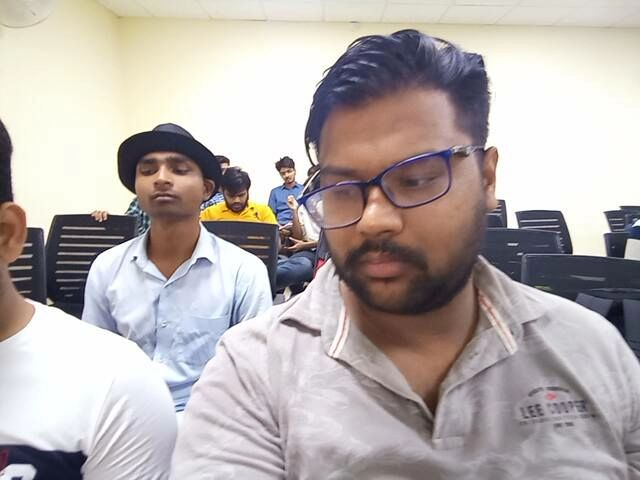

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
filename

'photo.jpg'

In [ ]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return (face_array, results)

# load the photo and extract the face
pixels, results = extract_face(filename)

In [ ]:
results

[{'box': [134, 145, 67, 75],
  'confidence': 0.9999990463256836,
  'keypoints': {'left_eye': (149, 170),
   'mouth_left': (152, 200),
   'mouth_right': (177, 199),
   'nose': (161, 180),
   'right_eye': (179, 169)}},
 {'box': [315, 99, 163, 205],
  'confidence': 0.9999868869781494,
  'keypoints': {'left_eye': (346, 188),
   'mouth_left': (358, 266),
   'mouth_right': (412, 262),
   'nose': (371, 222),
   'right_eye': (416, 177)}},
 {'box': [279, 167, 14, 15],
  'confidence': 0.998377799987793,
  'keypoints': {'left_eye': (283, 173),
   'mouth_left': (285, 180),
   'mouth_right': (290, 178),
   'nose': (286, 176),
   'right_eye': (289, 171)}},
 {'box': [224, 184, 23, 26],
  'confidence': 0.9951556921005249,
  'keypoints': {'left_eye': (231, 193),
   'mouth_left': (232, 205),
   'mouth_right': (241, 205),
   'nose': (236, 201),
   'right_eye': (242, 193)}}]

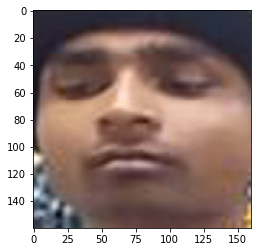

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pixels)

In [ ]:
import numpy
from keras.models import load_model


In [ ]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = numpy.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
face_pixels=pixels

In [ ]:

model = load_model('/content/drive/MyDrive/Training Images/facenet/facenet_keras.h5')
print('Loaded Model')
face_pixels = face_pixels
yhat = get_embedding(model, face_pixels)


Loaded Model


In [ ]:

# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

In [ ]:
from numpy import load

In [ ]:
data = load('/content/drive/MyDrive/Training Images/faces-dataset1.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('/content/drive/MyDrive/Training Images/faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model1 = SVC(kernel='linear', probability=True)
model1.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [ ]:
newTestX = list()

In [ ]:
newTestX.append(yhat)

In [ ]:
newTestX = numpy.asarray(newTestX)

In [ ]:
print(newTestX.shape)

(1, 128)


In [ ]:

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(newTestX)

In [ ]:
yhat_class = model1.predict(trainX)
yhat_prob = model1.predict_proba(trainX)

In [ ]:
yhat_class
yhat_prob

array([[0.82583868, 0.11672092, 0.01997494, 0.03746546]])

In [ ]:
asli_name = yhat_class[0]
asli_name = yhat_class[0]
class_probability = yhat_prob[0,asli_name] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
#print('Expected: %s' % random_face_name[0])

Predicted: AJEET (82.584)


In [ ]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN


# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

import numpy
from keras.models import load_model
from PIL import Image

from IPython.display import display

In [ ]:

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 

def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = numpy.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]



In [ ]:
model = load_model('/content/drive/MyDrive/Training Images/facenet/facenet_keras.h5')
print('Loaded Model')

data1 = load('/content/drive/MyDrive/Training Images/faces-dataset1.npz')
data = load('/content/drive/MyDrive/Training Images/faces-embeddings.npz')

Loaded Model


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


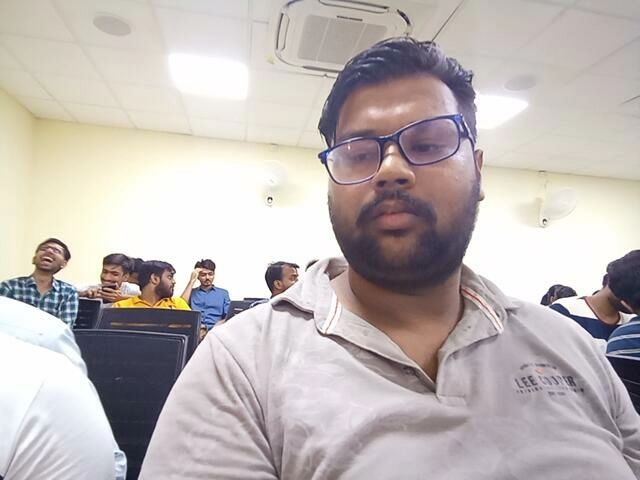

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

SVC(kernel='linear', probability=True)

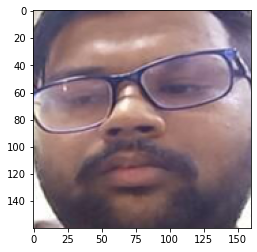

In [ ]:
from PIL import Image

# load the photo and extract the face
face_pixels = extract_face(filename)
display(pyplot.imshow(face_pixels))



yhat = get_embedding(model, face_pixels)


testX_faces = data1['arr_2']
# load face embeddings

trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model1 = SVC(kernel='linear', probability=True)
model1.fit(trainX, trainy)

In [ ]:
newTestX = list()
newTestX.append(yhat)
newTestX = numpy.asarray(newTestX)


# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(newTestX)

yhat_class = model1.predict(trainX)
yhat_prob = model1.predict_proba(trainX)

asli_name = yhat_class[0]
asli_name = yhat_class[0]
class_probability = yhat_prob[0,asli_name] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
#print('Expected: %s' % random_face_name[0])

Predicted: PRANJAL (88.459)


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 5.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Efficient net

In [ ]:

import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [ ]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import efficientnet.keras as efn

In [ ]:
train_dir  = "/content/drive/MyDrive/Training Images/Final_data/train"
validation_dir = "/content/drive/MyDrive/Training Images/Final_data/val"

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 3275 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [ ]:

base_model = EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

258088960/258076736 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
effi = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 15)

Epoch 1/15
100/100 [==============================] - 77s 571ms/step - loss: 15.6687 - accuracy: 0.1770 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/15
100/100 [==============================] - 53s 528ms/step - loss: 1.6233 - accuracy: 0.1915 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/15
100/100 [==============================] - 52s 522ms/step - loss: 1.6320 - accuracy: 0.2025 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/15
100/100 [==============================] - 52s 516ms/step - loss: 1.6150 - accuracy: 0.2090 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 5/15
100/100 [==============================] - 52s 524ms/step - loss: 1.6190 - accuracy: 0.2090 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 6/15
100/100 [==============================] - 52s 518ms/step - loss: 1.6094 - accuracy: 0.2000 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 7/15
100/100 [==============================] - 52s 516ms/step - loss: 1.6101 - accuracy: 0.1965 - val_loss: 1.6095 - val_a

KeyboardInterrupt: ignored

#VGG19


In [ ]:
import os 
import zipfile 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
train_dir = '/content/drive/MyDrive/Training Images/Final_data/train'
validation_dir = '/content/drive/MyDrive/Training Images/Final_data/val'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 3275 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 15)

Epoch 1/15
100/100 [==============================] - 43s 425ms/step - loss: 0.7236 - acc: 0.7390 - val_loss: 0.3346 - val_acc: 0.8670
Epoch 2/15
100/100 [==============================] - 42s 418ms/step - loss: 0.2048 - acc: 0.9238 - val_loss: 0.5426 - val_acc: 0.8020
Epoch 3/15
100/100 [==============================] - 42s 419ms/step - loss: 0.1355 - acc: 0.9574 - val_loss: 0.4716 - val_acc: 0.8270
Epoch 4/15
100/100 [==============================] - 42s 420ms/step - loss: 0.0915 - acc: 0.9675 - val_loss: 1.2147 - val_acc: 0.7430
Epoch 5/15
100/100 [==============================] - 42s 421ms/step - loss: 0.0925 - acc: 0.9679 - val_loss: 0.9437 - val_acc: 0.7620
Epoch 6/15
100/100 [==============================] - 43s 428ms/step - loss: 0.0517 - acc: 0.9795 - val_loss: 0.7877 - val_acc: 0.7700
Epoch 7/15
100/100 [==============================] - 42s 421ms/step - loss: 0.0625 - acc: 0.9800 - val_loss: 0.8708 - val_acc: 0.7750
Epoch 8/15
100/100 [==============================] - 4

In [ ]:
pwd

'/content'

In [ ]:
model.save('/content/drive/MyDrive/Final_model/VGG20.h5')

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Final_model/VGG20.h5")
 
#score = model.evaluate(valx, valy)
 
#print('Test loss:', score[0]) 
#print('Test accuracy:', score[1])
 

#pred = model.predict(valx) 
#pred = np.argmax(pred, axis = 1)[:4]
#label = np.argmax(valy,axis = 1)[:4]
 
#print("Predicted labels:",pred) 
#print("Actual Labels:   ",label)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
img_path = "/content/drive/MyDrive/Training Images/Final_data/val/RAJ/image71299.0.jpg"

In [ ]:
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
pred = model.predict(img_batch)


In [ ]:
np.argmax(pred)

4

In [ ]:
img_batch.shape

(1, 224, 224, 3)

In [ ]:
import winsound
winsound.Beep(440, 500)

ModuleNotFoundError: ignored

In [ ]:

display(IPython.display.Audio(url="https://www.soundjay.com/buttons/sounds/beep-04.mp3", autoplay=True))
sleep(1)
display(IPython.display.Audio(url="https://www.soundjay.com/buttons/sounds/beep-04.mp3", autoplay=True))